# CodEbot
-------------------------------

**Contributers:** Nguyen Vuong, Tam Luong <br>
**Tutor:** Hung Nguyen


# Introduction

## Workflow
<div style="text-align: center;">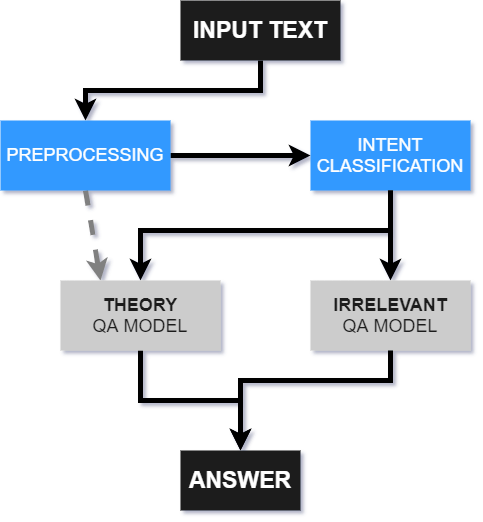</div>


# Preprocessing

- **Libraries use for this stage:** sklearn, underthesea, VietnameseTextNormalizer <br>
- **Steps:**
    - Normalize Vietnamese document (spell, syntax, ...)
    - Converting to lower case
    - Word tokenizing using Vietnamese work tokenizer of underthesea
    - Word embedding using tf-idf vectorizer of sklearn
- **Pipeline:**
<div style="text-align:center;">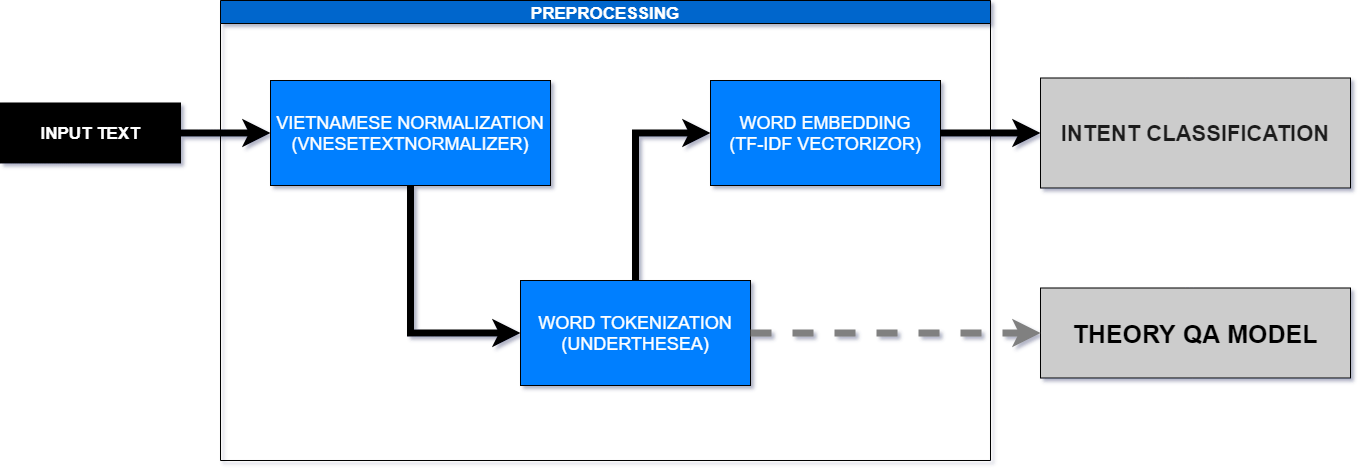</div>


## Import libraries

In [1]:
import os
import errno
import shutil
import time
import random
import re

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from underthesea import word_tokenize

import joblib

## Define Preprocessing

In [2]:
class Preprocessing:
    def __init__(self, input='content', encoding='utf-8', decode_error='strict', strip_accents=None, 
                 lowercase=True, preprocessor=None, tokenizer=None, analyzer='word', stop_words=None, 
                 token_pattern='(?u)\b\w\w+\b', ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None, 
                 vocabulary=None, binary=False, dtype=np.float64, norm='l2', use_idf=True, smooth_idf=True, 
                 sublinear_tf=False):
        if (tokenizer == None):
            self._tokenizer = word_tokenize
        else:
            self._tokenizer = tokenizer
        
        self._vectorizer = TfidfVectorizer(
            input=input, encoding=encoding, decode_error=decode_error, strip_accents=strip_accents, 
            lowercase=lowercase, preprocessor=preprocessor, tokenizer=self._tokenizer, analyzer=analyzer, 
            stop_words=stop_words, token_pattern=token_pattern, ngram_range=ngram_range, 
            max_df=max_df, min_df=min_df, max_features=max_features, vocabulary=vocabulary, binary=binary, 
            dtype=dtype, norm=norm, use_idf=use_idf, smooth_idf=smooth_idf, sublinear_tf=sublinear_tf)
        
    def fit(self, df):
        self._vectorizer.fit(self.optional_preprocess(df))
        return self
    
    def fit_transform(self, df):
        return self._vectorizer.fit_transform(self.optional_preprocess(df))
        
    def transform(self, df):
        """
        Vectorize Pandas DataFrame
        """
        return self._vectorizer.transform(self.optional_preprocess(df))
    
    def optional_preprocess(self, df):
        return df.apply(lambda q: re.sub('[cC]\+\+', 'cpp', q))
    
    def save(self, file_name):
        print("Saving model to ", file_name)
        return joblib.dump(self, file_name)
        
    @staticmethod
    def load(file_name):
        if (isinstance(file_name, str) and os.path.isfile(file_name)):
            self = joblib.load(file_name)
        else:
            raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), file_name)
        return self

## Import dataset

In [3]:
if (os.path.basename(os.getcwd()) != "CodEbot"):
    os.chdir('../')

data = pd.read_csv("./data/data.csv")

X = data.question
y = data[["intent", "context"]]

data.sample(frac=1).head(15)

intent  context                                           question
51        apply      cpp  Mình muốn hỏi template hàm có ứng dụng gì tron...
304       other  general                                  thông tin covid19
260        help  general                 mình có thắc mắc không biết hỏi ai
341         tip      cpp                        có mẹo gì hay về C++ không?
149      define      cpp                         Namespace trong C++ là gì?
325  references  general                cho mình xin tài liệu học lập trình
186      define  general             Ý nghĩa của "vptr" trong hàm ảo là gì?
189    disagree  general                                   codebot nhầm rồi
240        help      cpp         Chào codebot, mình đang đau đầu vì C++ đây
337  references  general                                   cho xin tài liệu
153      define      cpp       Tôi muốn biết encapsulation trong C++ là gì?
173      define  general                              Const function là gì?
42        agree  general                                            ừa hehe
104     compare  general        Hãy phân biệt Syntax error và Runtime error
318  references      cpp                             có tài liệu C++ không?

## Import Programming Corpus

In [4]:
corpus_path = './data/programming_corpus'
corpus = [X]
for name in ['Array_Char_String_Struct_Cpp', 'Ham_For_While', 'c++']:
    with open(f'{corpus_path}/{name}.txt', 'r', encoding='utf-8') as f:
        tmp = list(filter(lambda s: len(s) , f.read()[1:].replace('.', '\n').split('\n')))
        corpus.append(pd.Series(tmp))

tfidf_data = pd.concat(corpus, ignore_index=True)
tfidf_data

0                      cậu biết ý tớ đó
1            câu trả lời thật là bổ ích
2       câu trả lời thật là bổ ích đó ạ
3                           chắc là vậy
4                              chắc thế
                     ...               
1067                               mau;
1068                           cout<<ps
1069                        tu<<”/”<<ps
1070                              mau; 
1071                                   
Length: 1072, dtype: object

## Fit the preprocessing model with dataset and corpus

In [5]:
tfidf__ngram_range = (1, 2)
tfidf__max_df = 1.0
tfidf__min_df = 3

preprocessor = Preprocessing(ngram_range=tfidf__ngram_range, max_df=tfidf__max_df, min_df=tfidf__min_df)
preprocessor.fit(tfidf_data)

preprocessor.save("./src/codebot/model/preprocessing_1.bin")

C:\Users\giaph\Anaconda3\envs\pytorch\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Saving model to  ./src/codebot/model/preprocessing_1.bin


['./src/codebot/model/preprocessing_1.bin']

# Intent Classification

- **Libraries use for this stage:** sklearn <br>
- **Model:** LinearSVC
- **Steps:**
    - Splitting pre-processed data into train set and test set for model evaluation.
    - Fitting train set to LinearSVC model.
    - Validating model evaluation on train set and test set with f1 score (micro averaging).

- **Pipeline:**
<div style="text-align:center;">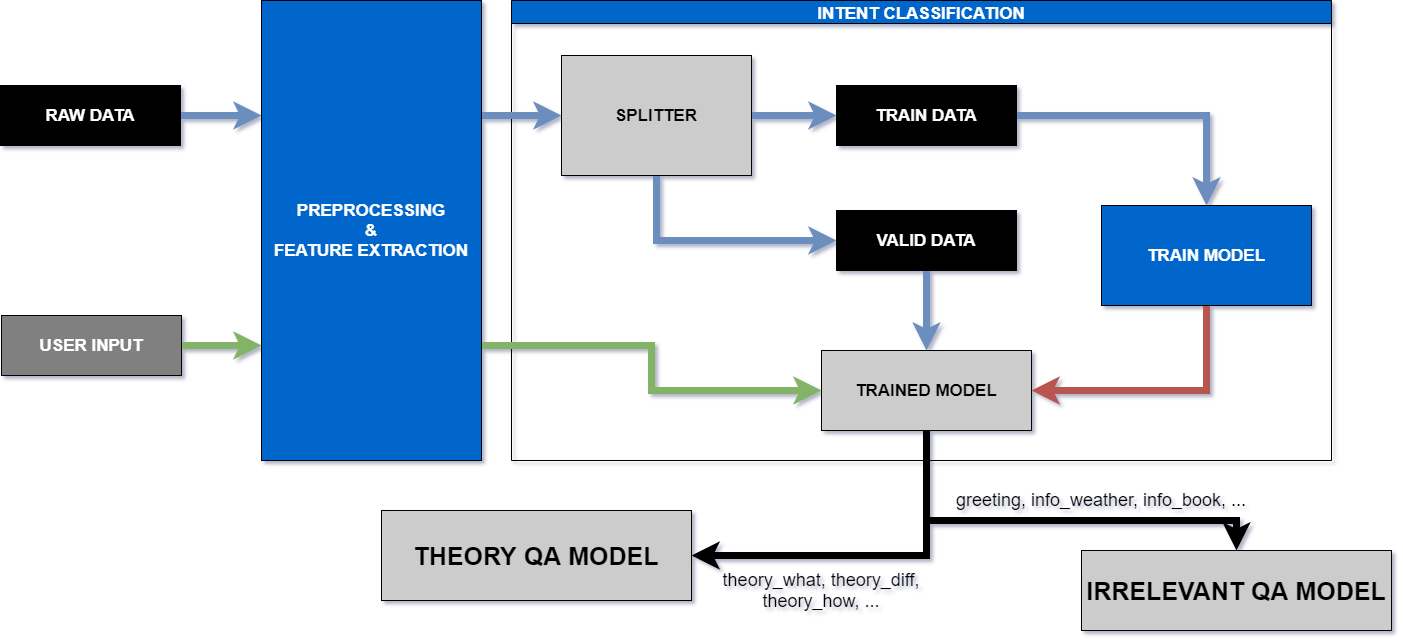</div>


## Import libraries

In [6]:
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split

## Evaluate

In [7]:
def micro_f1_score(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')

In [8]:
pre = Preprocessing.load("./src/codebot/model/preprocessing_1.bin")

# print(pre._vectorizer.get_feature_names())
X_processed = pre.transform(X)

In [9]:
C = {
    "intent": 0.5,
    "context": 100
}

for column in ["intent", "context"]:
    X_train, X_test, y_train, y_test = train_test_split(X_processed, y[column], test_size=0.2, random_state=46,stratify=y[column])
    
    model = LinearSVC(C=C[column], random_state=46)
    model.fit(X_train, y_train)
    
    pred = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    print(f"micro f1_score of TRAIN_{column}: {micro_f1_score(pred, y_train)}\n")
    print(f"classification_report of TRAIN_{column}:\n{classification_report(y_train, pred, labels=model.classes_)}")
    print(f"micro f1_score of TEST_{column}: {micro_f1_score(pred_test, y_test)}\n")
    print(f"classification_report of TEST_{column}:\n{classification_report(y_test, pred_test, labels=model.classes_)}")

micro f1_score of TRAIN_intent: 0.9928825622775801

classification_report of TRAIN_intent:
              precision    recall  f1-score   support

       agree       1.00      0.95      0.97        37
       apply       1.00      1.00      1.00        26
     compare       1.00      1.00      1.00        26
 credit_info       1.00      1.00      1.00        19
      define       1.00      1.00      1.00        41
    disagree       1.00      1.00      1.00        25
    greeting       1.00      1.00      1.00        14
        help       1.00      1.00      1.00        27
       other       0.95      1.00      0.97        35
  references       1.00      1.00      1.00        21
         tip       1.00      1.00      1.00        10

    accuracy                           0.99       281
   macro avg       1.00      1.00      0.99       281
weighted avg       0.99      0.99      0.99       281

micro f1_score of TEST_intent: 0.8732394366197183

classification_report of TEST_intent:
       

## Retrain & Save model

In [10]:
for column in ["intent", "context"]:
    model = LinearSVC(C=C[column], random_state=46)
    model.fit(X_processed, y[column])

    pred = model.predict(X_processed)

    print(f"f1_score of AllData_{column}: {micro_f1_score(pred, y[column])}")
    
    joblib.dump(model, f"./src/codebot/model/model_{column}_1.bin")

f1_score of AllData_intent: 0.9914772727272727
f1_score of AllData_context: 1.0
